# How to classify surnames with RNN

We follow the tutorial available at: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

We build a classifier for surnames from scratch (pre-processing included), using character-level RNN, which predicts which among 18 languages the surname is most likely from.

## The data
The data is available at: https://download.pytorch.org/tutorial/data.zip

The folder `data/names` contains 18 Unicode text files, one for each of 18 languages, with names such as `[Language].txt`.

With the following code we read the files, convert the data to ASCII and create a dictionary with shape `{language: [name1, name2, ...]}` 

In [1]:
# import a few packages
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
# get paths of the language files 
def findFiles(path): return glob.glob(path)
print(findFiles('data/names/*.txt'))

['data/names/Greek.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/English.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Italian.txt', 'data/names/Russian.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'" # define the alphabet
n_letters = len(all_letters) # size of alphabet

# from Unicode string to plain ASCII, following https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# for example:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
# define a function to read a file, convert and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [5]:
# build the dictionary, a list of names for each language
category_dict = {} # init empty dict
all_categories = [] # init empty list

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] # get language name from file path
    all_categories.append(category)
    names = readLines(filename)
    category_dict[category] = names

In [6]:
# inspect the data a bit
n_categories = len(all_categories)
print(n_categories)
print(category_dict.keys())
print(category_dict['Italian'][:5])

18
dict_keys(['Dutch', 'Arabic', 'Portuguese', 'Italian', 'Irish', 'Greek', 'Polish', 'Korean', 'German', 'Spanish', 'Czech', 'Japanese', 'Chinese', 'Vietnamese', 'Scottish', 'English', 'Russian', 'French'])
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## From names to tensors

We use one-hot encoding for the letters: each letter is encoded in a vector of 0s and 1s, whose length is equal to the cardinality of the alphabet; for example: letter `a = [1,0,0,0,...]`, letter `b = [0,1,0,0,...]` and so on. 

The encoding of a word is then obtained as a matrix whose rows are the encodings of the letters of the name.

In [7]:
# define a function to find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# example
letterToIndex("k")

10

In [8]:
# first import torch to define tensors
import torch

# define a function to turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters) # first, all positions to 0; 1 as first argument is dimension of tensor
    tensor[0][letterToIndex(letter)] = 1 # then set the index position to 1
    return tensor

# example:
letterToTensor("k")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [9]:
# define a function to convert a word into a matrix of one-hot encodings
def wordToTensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#example:
wordToTensor("hey")

tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

## The neural network

The RNN is quite simple: just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output (see https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net).

In [10]:
import torch.nn as nn # we customize the nn.Module

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # layer from input to hidden state
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # layer from input to output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # the source of recurrency: input and hidden are combined here
        hidden = self.i2h(combined) # the result is fed to linear transformation going to hidden layer itself
        output = self.i2o(combined) # and to output layer
        output = self.softmax(output) # which is then softmax-transformed to probability over categories
        return output, hidden

    def initHidden(self): # init hidden layer with zeros
        return torch.zeros(1, self.hidden_size)

In [11]:
# build the network setting a few parameteres
n_hidden = 128 # size of hidden layer

rnn = RNN(n_letters, n_hidden, n_categories) # n_categories is defined above

Let's look at an example of a forward pass of the network, i.e. with a letter-tensor and "empty" hidden state as input:

In [12]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output)

tensor([[-3.0296, -2.9656, -2.8694, -2.8646, -2.7999, -2.9430, -2.8141, -3.0300,
         -2.8564, -2.9117, -2.7906, -2.9543, -2.9406, -2.8077, -2.8330, -2.8690,
         -2.8456, -2.9493]], grad_fn=<LogSoftmaxBackward>)


A more efficient way to do this is to compute the word-tensor once and using slices for each letter:

In [13]:
input = wordToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0296, -2.9656, -2.8694, -2.8646, -2.7999, -2.9430, -2.8141, -3.0300,
         -2.8564, -2.9117, -2.7906, -2.9543, -2.9406, -2.8077, -2.8330, -2.8690,
         -2.8456, -2.9493]], grad_fn=<LogSoftmaxBackward>)


## Training

First, we define a couple of helper functions. The first of them makes it easier to interpret the output of the nn: it takes the probability distribution yielded by softmax and returns the most likely language according to the distributions

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # .topk is a method of tensors
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 10)


Next, we define a function which yields a random training example (a name with its language):

In [15]:
import random

def randomChoice(l): # extract a random element from a list
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) # extract a random language
    word = randomChoice(category_dict[category]) # extract a random name from the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # language index as tensor
    word_tensor = wordToTensor(word) # the tensor associated with the word
    return category, word, category_tensor, word_tensor

For example:

In [16]:
randomTrainingExample()

('Greek',
 'Kapsimalles',
 tensor([0]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

More examples:

In [17]:
for i in range(10):
    category, word, category_tensor, word_tensor = randomTrainingExample()
    print('language =', category, '/ name =', word)

language = Korean / name = Ngai
language = Portuguese / name = De santigo
language = Japanese / name = Tenshin
language = German / name = Klossner
language = German / name = Regenbogen
language = English / name = Whittaker
language = Greek / name = Polites
language = Arabic / name = Asker
language = Polish / name = Szwarc
language = Dutch / name = Penners


We can now move to training the nn. We use negative likelihood as loss function:

In [18]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # how to optimize this hyper-par?

We write a function which takes a training example <name,language>, compute nn's prediction given the name

In [19]:
def train(category_tensor, word_tensor):
    hidden = rnn.initHidden() # initialize hidden ;ayer

    rnn.zero_grad()

    for i in range(word_tensor.size()[0]): # feed forward for each character of the name
        output, hidden = rnn(word_tensor[i], hidden)

    loss = criterion(output, category_tensor) # compute loss
    loss.backward() # and its gradients

    # Add parameters' gradients to their values, multiplied by learning rate: update weights
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

For example:

In [20]:
category, word, category_tensor, word_tensor = randomTrainingExample()
output, loss = train(category_tensor, word_tensor)
print(category)
print(output)
print(categoryFromOutput(output))
print(loss)

Portuguese
tensor([[-2.9234, -2.9220, -2.9202, -2.9957, -2.8548, -2.9586, -2.8776, -3.0040,
         -2.8102, -2.8573, -2.8430, -2.8858, -2.9945, -2.8282, -2.8035, -2.9170,
         -2.7533, -2.9202]], grad_fn=<LogSoftmaxBackward>)
('Italian', 16)
2.920182466506958


Finally, we loop the `train` function, iteratively updating the weights and loss:

In [21]:
import time
import math

n_iters = 200000
print_every = 10000 # we don't want to print or plot every value
plot_every = 1500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 5% (0m 34s) 0.4383 Georgeakopoulos / Greek ✓
20000 10% (1m 7s) 2.3306 Silva / Spanish ✗ (Portuguese)
30000 15% (1m 42s) 1.8967 Donndubhan / Scottish ✗ (Irish)
40000 20% (2m 17s) 2.8018 Abeln / Irish ✗ (German)
50000 25% (2m 49s) 0.2943 Ansaldi / Italian ✓
60000 30% (3m 22s) 0.0726 O'Doherty / Irish ✓
70000 35% (3m 55s) 0.1517 Bekyros / Greek ✓
80000 40% (4m 28s) 1.2881 Melo / Spanish ✗ (Portuguese)
90000 45% (5m 0s) 0.5576 Krytinar / Czech ✓
100000 50% (5m 33s) 0.0360 Bukoski / Polish ✓
110000 55% (6m 5s) 1.1637 Aldebrandi / Italian ✓
120000 60% (6m 38s) 4.7126 Lizander / German ✗ (Russian)
130000 65% (7m 12s) 1.5285 Michel / Dutch ✓
140000 70% (7m 49s) 1.2618 Ellard / English ✓
150000 75% (8m 22s) 1.9807 Kim / Korean ✗ (Vietnamese)
160000 80% (8m 53s) 1.2311 Kowalski / Japanese ✗ (Polish)
170000 85% (9m 27s) 0.5546 Sgro / Italian ✓
180000 90% (10m 0s) 0.3020 Gzovsky / Russian ✓
190000 95% (10m 35s) 3.0584 Pavlu / Spanish ✗ (Czech)
200000 100% (11m 8s) 1.8813 Rios / Korean ✗ (Por

Let's plot the history of loss:

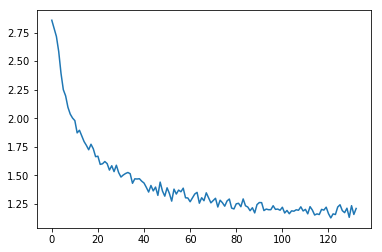

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluation

We use confusion matrix: for each actual language (in the rows) we display with heat map how many times each language (in the columns) was predicted by the network.

To do so, we define a function called `evaluate` which is basically the same as `train` above but without backpropagation: `evaluate` takes a trained network and applies feed-forward it to a batch of input data, collecting the output which will be fed to the confusion matrix:

In [23]:
confusion = torch.zeros(n_categories, n_categories) # keep track of correct guesses in this matrix
n_confusion = 10000 # we run the network on this many examples

# return an output given a word
def evaluate(word_tensor):
    hidden = rnn.initHidden()

    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)

    return output

We run this function `n_confusion` times:

In [24]:
# for every example, run the nn and record which are correctly guessed
for i in range(n_confusion):
    category, word, category_tensor, word_tensor = randomTrainingExample() # extract random example
    output = evaluate(word_tensor) # run the nn
    guess, guess_i = categoryFromOutput(output) # extract prediction
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1 # append to matrix

# then normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

Finally, let's plot the heat map:

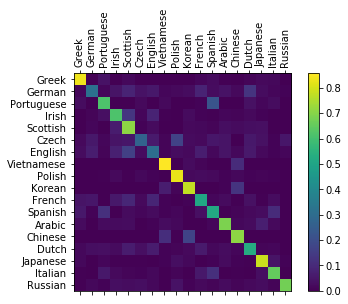

In [25]:
# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Ideally, the diagonal should contain the brightest spots, and we can see that in general that's not too far from being true. There are execptions: English is not particularly well-recognized, Spanish is sometimes confused with Portuguese, Korean is mistaken for Chinese and Italian for Spanish.

## Running on user input

We define a function which leverages the pre-trained nn to infer the language of a name provided by the user:

In [26]:
def predict(input_word, n_predictions=3):
    print('\n> %s' % input_word)
    with torch.no_grad():
        output = evaluate(wordToTensor(input_word))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [27]:
# for example:
predict("Rossi")


> Rossi
(-0.08) Italian
(-3.33) Arabic
(-4.52) Japanese


(smaller absolute values mean higher likelihood)

In [28]:
predict("Heinz")


> Heinz
(-0.80) Vietnamese
(-1.80) German
(-1.85) Chinese


In [29]:
predict("Choi")


> Choi
(-0.34) Korean
(-1.72) Chinese
(-3.15) Vietnamese


It works! :)

## Future improvements...?

Try the `nn.LSTM` and `nn.GRU` layers.